In [2]:
import pickle

with open('../data/processed/train-processed-v2.pkl', 'rb') as f:
    train = pickle.load(f)
    
with open('../data/processed/test-processed-v2.pkl', 'rb') as f:
    test = pickle.load(f)
    
train.columns.to_numpy()

array(['Fuel Consumption City (l/100km)',
       'Fuel Consumption Hwy (l/100km)',
       'Fuel Consumption Comb (l/100km)', 'Engine Size(L)', 'Cylinders',
       'Id', 'Make', 'Vehicle Class', 'Transmission', 'Fuel Type',
       'CO2 Emissions(g/km)'], dtype=object)

In [3]:
# Bagi data menjadi fitur dan target
features = train.drop('CO2 Emissions(g/km)', axis=1)
target = train['CO2 Emissions(g/km)']

In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t_0 = time.time()
    if verbose == False:
        model.fit(X_train, y_train, verbose=0)
    else:
        model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    time_taken = time.time() - t_0
    
    print("RMSE = {}".format(rmse))
    
    return model, rmse, time_taken

In [5]:
# Split data for performance testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

Training with Different Models

In [37]:
from xgboost import XGBRegressor

params_xgb = {
    'objective': 'reg:squarederror',  # Specify the objective for regression tasks
    'colsample_bytree': 0.8,          # Fraction of features to be randomly sampled for each tree
    'learning_rate': 0.07,             # Step size shrinkage to prevent overfitting
    'max_depth': 64,                  # Maximum depth of a tree
    'alpha': 10,                      # L1 regularization term on weights
    'n_estimators': 10000,              # Number of boosting rounds
    'subsample': 0.8,                 # Fraction of samples used for each boosting round
    'random_state': 41230
}

model_xgb = XGBRegressor(**params_xgb)
model_xgb, rmse_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

RMSE = 34.78222021587327


In [41]:
import lightgbm as lgb

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params_lgb = {
    'objective': 'regression',  # 'regression' for regression tasks
    'metric': 'rmse',           # Root Mean Squared Error (RMSE) for regression
    'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    'num_leaves': 512,           # Maximum tree leaves for base learners
    'learning_rate': 0.08,
    'feature_fraction': 0.9
}

num_round = 100

t_0 = time.time()

model_lgb = lgb.train(params_lgb, train_data, num_round, valid_sets=[test_data])
y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred))

time_taken = time.time() - t_0
tt_lgb = time_taken

print("RMSE = {}".format(rmse_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 102855, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 242.257585
RMSE = 33.47753885335714


In [8]:
from sklearn.ensemble import RandomForestRegressor

params_rf = {
    'n_estimators': 10000,
    'max_depth': 64,
    'n_jobs': -1,
    'verbose': 1,
    'warm_start': True,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'bootstrap': True,
    'oob_score': True,
    'criterion': 'squared_error',
    'random_state': 41230
}

model_rf = RandomForestRegressor(**params_rf)
model_rf, rmse_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 10000 out of 

RMSE = 33.69322818090772


[Parallel(n_jobs=8)]: Done 10000 out of 10000 | elapsed:   40.6s finished


In [9]:
def evaluate(model, test_features, test_labels):
    t_0 = time.time()
    
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    rmse = np.sqrt(mean_squared_error(test_labels, predictions))
    
    time_taken = time.time() - t_0
    
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('RMSE = {:0.2f}%.'.format(rmse))
    
    return model, rmse, time_taken

In [10]:
# # Hyperparameter tuning with GridSearchCV
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [8, 16, 32, 48],
#     # 'max_features': [None, 'sqrt', 'log2', 0.1, 0.5, 0.9],
#     # 'min_samples_leaf': [3, 4, 5],
#     # 'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# model_rfg = RandomForestRegressor()
# model_gs = GridSearchCV(estimator=model_rfg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# # Fit grid search to find the best model
# model_gs.fit(X_train, y_train)
# model_gs.best_params_

# model_gs_best = model_gs.best_estimator_

In [15]:
# model_gs, grid_rmse, tt_gs = evaluate(model_gs_best, X_test, y_test)

# print('Improvement of {:0.2f}%.'.format( 100 * (grid_rmse - rmse_rf) / rmse_rf))

In [19]:
from sklearn.linear_model import ElasticNetCV

alpha_space = np.linspace(0.01, 1, 100)

params_elcv = {
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
    'alphas': alpha_space,
    'cv': 10,
    'max_iter': 100000,
    'random_state': 128
}

model_elcv = ElasticNetCV(**params_elcv)
model_elcv, rmse_elcv, tt_elcv = run_model(model_elcv, X_train, y_train, X_test, y_test)

RMSE = 46.23089247456918


In [20]:
from sklearn.linear_model import LassoCV

params_lcv = {
    'alphas': alpha_space,
    'cv': 10,
    'max_iter': 100000,
    'random_state': 128
}

model_lcv = LassoCV(**params_lcv)
model_lcv, rmse_lcv, tt_lcv = run_model(model_lcv, X_train, y_train, X_test, y_test)

RMSE = 46.23089247456918


In [16]:
from sklearn.neighbors import KNeighborsRegressor

params_knn = {
    'n_neighbors': 5,
    'weights': 'distance',
    'algorithm': 'auto',
    'leaf_size': 30,
    'p': 2,
    'metric': 'minkowski',
    'n_jobs': -1
}

model_knn = KNeighborsRegressor(**params_knn)
model_knn, rmse_knn, tt_knn = run_model(model_knn, X_train, y_train, X_test, y_test)

RMSE = 61.74894512751282


In [18]:
from sklearn.svm import SVR

params_svr = {
    'kernel': 'rbf',
    'degree': 3,
    'gamma': 'scale',
    'coef0': 0.0,
    'tol': 0.001,
    'C': 1.0,
    'epsilon': 0.1,
    'shrinking': True,
    'cache_size': 200,
    'verbose': False,
    'max_iter': -1
}

model_svr = SVR(**params_svr)
model_svr, rmse_svr, tt_svr = run_model(model_svr, X_train, y_train, X_test, y_test)

RMSE = 62.94335257299199


In [27]:
from sklearn.tree import DecisionTreeRegressor

params_dtr = {
    'criterion': 'squared_error',
    'splitter': 'best',
    'max_depth': 128,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'min_weight_fraction_leaf': 0.0,
    'random_state': 128,
    'min_impurity_decrease': 0.0,
}

model_dtr = DecisionTreeRegressor(**params_dtr)
model_dtr, rmse_dtr, tt_dtr = run_model(model_dtr, X_train, y_train, X_test, y_test)

RMSE = 47.411349057519104


In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 16, 32, 64, 128],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'random_state': [128],
}

model_dtrcv = DecisionTreeRegressor()

grid_search = GridSearchCV(model_dtrcv, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model_dtrcv = grid_search.best_estimator_

In [30]:
model_dtrcv, rmse_dtrcv, tt_dtrcv = evaluate(best_model_dtrcv, X_test, y_test)

Average Error: 23.3741 degrees.
RMSE = 36.35%.


Model             RMSE       Time taken 
Decision Tree     47.411349  1.344876       1
Decision Tree CV  36.353423  0.013720       1
ElasticNet        46.230892  4.110443       1
KNN               61.748945  0.307843       1
Lasso             46.230892  0.662832       1
LightGBM          34.065439  0.660145       1
Random Forest     33.693228  813.784943     1
SVR               62.943353  1784.322954    1
XGBoost           34.782220  496.901495     1
Name: count, dtype: int64


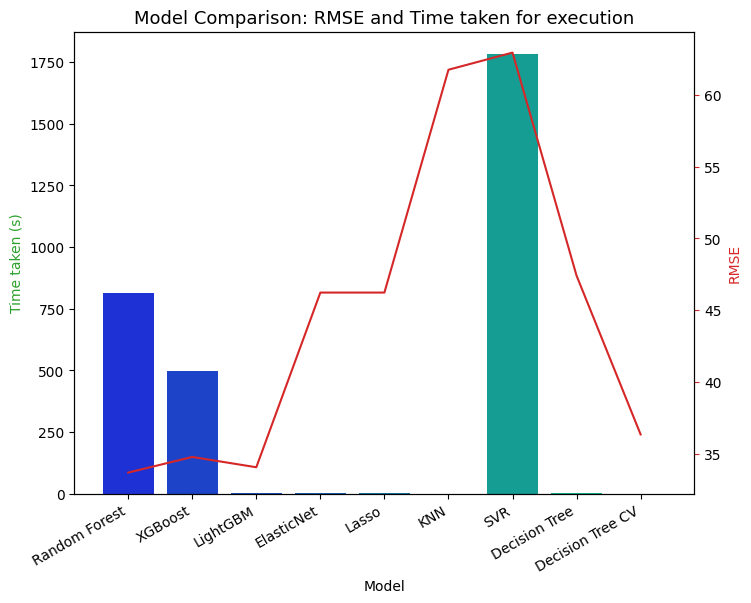

In [38]:
import pandas as pd
import seaborn as sns

rmse = [rmse_rf, rmse_xgb, rmse_lgb, rmse_elcv, rmse_lcv, rmse_knn, rmse_svr, rmse_dtr, rmse_dtrcv]
tt = [tt_rf, tt_xgb, tt_lgb, tt_elcv, tt_lcv, tt_knn, tt_svr, tt_dtr, tt_dtrcv]

model_data = {'Model': ['Random Forest', 'XGBoost', 'LightGBM', 'ElasticNet', 'Lasso', 'KNN', 'SVR', 'Decision Tree', 'Decision Tree CV'],
              'RMSE': rmse,
              'Time taken': tt}
model_data = pd.DataFrame(model_data)

score = model_data[['Model', 'RMSE', 'Time taken']].value_counts()
print(score)

fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_title('Model Comparison: RMSE and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Time taken (s)', fontsize=10, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = model_data, hue='Model', legend=False, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('RMSE', fontsize=10, color=color)
ax2 = sns.lineplot(x='Model', y='RMSE', data = model_data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=30, ha='right')

plt.show()